In [64]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

%matplotlib inline

import sys
try:
    #sys.path.append('/home/enacom/Documentos/github/smart-automation/utils/')
    sys.path.append(r'C:\Users\ra-no\OneDrive\Documentos\GitHub\smart-automation\utils')
    from get_metrics import get_metrics
    from create_figures import create_figures
    for path in sys.path:
        print(path)
except ImportError:
    print('Import error')

Import error


In [65]:
df = pd.read_parquet('./data/1s/train_test_data.parquet')
df.head()

,Frequencia CMB,CV-1,PT-1,PT-2,PT-3
0,40.0,0.547607,-0.980835,6.745117,4.180664
1,40.0,0.569545,-0.980748,6.782366,4.125000
2,40.0,0.588588,-0.973145,6.764509,4.208705
3,40.0,0.559163,-0.969645,6.798177,4.164713
4,40.0,0.570940,-0.978655,6.791295,4.159598


In [66]:
for column in df.columns:
    df[column] = df[column].rolling(5).mean()

df.dropna(inplace=True)

In [67]:
n_anteriores = 4
n_posteriores = 1

for i in range(1,n_anteriores+1):
    df[f'PT-1(K-{i})'] = df['PT-1'].shift(i)
    df[f'PT-2(K-{i})'] = df['PT-2'].shift(i)
    df[f'PT-3(K-{i})'] = df['PT-3'].shift(i)
    
for i in range(-1,-(n_posteriores+1),-1):
    df[f'PT-1(K+{-i})'] = df['PT-1'].shift(i)
    df[f'PT-2(K+{-i})'] = df['PT-2'].shift(i)
    df[f'PT-3(K+{-i})'] = df['PT-3'].shift(i)

df.columns

Index(['Frequencia CMB', 'CV-1', 'PT-1', 'PT-2', 'PT-3', 'PT-1(K-1)',
       'PT-2(K-1)', 'PT-3(K-1)', 'PT-1(K-2)', 'PT-2(K-2)', 'PT-3(K-2)',
       'PT-1(K-3)', 'PT-2(K-3)', 'PT-3(K-3)', 'PT-1(K-4)', 'PT-2(K-4)',
       'PT-3(K-4)', 'PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)'],
      dtype='object')

In [68]:
df.isnull().sum()

Frequencia CMB    0
CV-1              0
PT-1              0
PT-2              0
PT-3              0
PT-1(K-1)         1
PT-2(K-1)         1
PT-3(K-1)         1
PT-1(K-2)         2
PT-2(K-2)         2
PT-3(K-2)         2
PT-1(K-3)         3
PT-2(K-3)         3
PT-3(K-3)         3
PT-1(K-4)         4
PT-2(K-4)         4
PT-3(K-4)         4
PT-1(K+1)         1
PT-2(K+1)         1
PT-3(K+1)         1
dtype: int64

In [69]:
df.dropna(inplace=True)

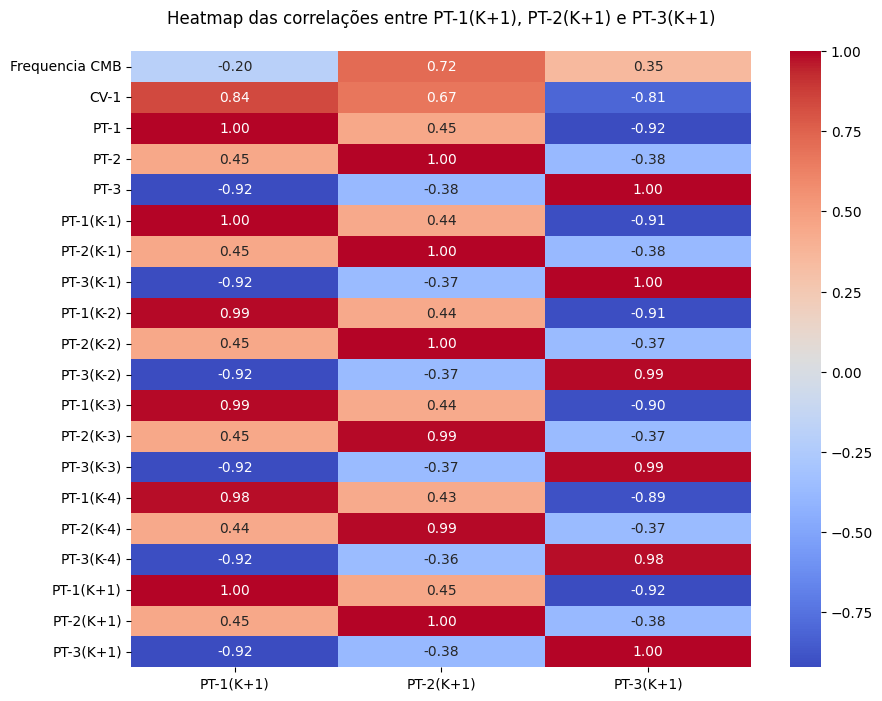

In [70]:
cols = ['PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)']
corr = df.corr()
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr[cols], annot=True, cmap='coolwarm', fmt=".2f")
heatmap.set_title('Heatmap das correlações entre PT-1(K+1), PT-2(K+1) e PT-3(K+1)', pad=20)
plt.show()

In [71]:
#Normalizando
data = tf.keras.utils.normalize(np.array(df), axis=1)
nor = np.linalg.norm(df, axis=1, keepdims=True)

In [72]:
from sklearn.model_selection import train_test_split

# Separando os dados em X e y
X = data[:, 0:17]
y = data[:, 17:]

X_train, X_test, y_train, y_test, nor_train, nor_test = train_test_split(X, y, nor, test_size=0.3, random_state=42, shuffle=True)

In [73]:
from sklearn.feature_selection import SelectKBest, f_regression

y_train_m = np.mean(y_train, axis=1)

selector = SelectKBest(score_func=f_regression, k='all')
fit = selector.fit(X_train, y_train_m)

scores = fit.scores_

df_scores = pd.DataFrame({'Feature': df.columns[:17], 'Score': scores}).sort_values(by='Score', ascending=False)
df_scores

,Feature,Score
3,PT-2,4786.050045
6,PT-2(K-1),4592.938858
9,PT-2(K-2),4300.849138
12,PT-2(K-3),3945.706383
15,PT-2(K-4),3610.361887
1,CV-1,1657.387053
0,Frequencia CMB,1542.683945
8,PT-1(K-2),1530.698471
5,PT-1(K-1),1527.417136
11,PT-1(K-3),1527.154397


In [74]:
from sklearn.ensemble import RandomForestRegressor

aux = df.copy()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(
    aux.drop(columns=cols),
    aux.filter(items=cols)
)

RandomForestRegressor(random_state=42)

In [75]:
feature_importances = pd.DataFrame(
    index=aux.drop(columns=cols).columns,
    data=rf.feature_importances_,
    columns=['Importância']
).sort_values(by='Importância', ascending=False)

feature_importances

,Importância
PT-2,0.919766
PT-3,0.041032
Frequencia CMB,0.019140
CV-1,0.012442
PT-2(K-1),0.002462
PT-3(K-1),0.001187
PT-2(K-2),0.000620
PT-1,0.000593
PT-1(K-3),0.000535
PT-1(K-2),0.000426


In [76]:
x_train = X_train[:, [3,6,1,5,0,4,2]]

In [77]:
# Adicionei um early stopping se o erro não cair por 100 épocas, para minimizar a hipótese de overfitting
from tensorflow.keras.callbacks import EarlyStopping


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(7))
model.add(tf.keras.layers.Dense(45,activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dense(45,activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dense(3,activation='linear'))


model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['mean_squared_error'])

early_stop = EarlyStopping(monitor='mean_squared_error', patience=150)

model.fit(x_train, y_train, epochs=5000, callbacks=[early_stop])

Epoch 1/5000
137/137 [==============================] - 1s 2ms/step - loss: 9.2451e-04 - mean_squared_error: 9.2451e-04
Epoch 2/5000
137/137 [==============================] - 0s 2ms/step - loss: 4.1708e-05 - mean_squared_error: 4.1708e-05
Epoch 3/5000
137/137 [==============================] - 0s 2ms/step - loss: 2.0978e-05 - mean_squared_error: 2.0978e-05
Epoch 4/5000
137/137 [==============================] - 0s 2ms/step - loss: 1.6190e-05 - mean_squared_error: 1.6190e-05
Epoch 5/5000
137/137 [==============================] - 0s 2ms/step - loss: 1.3800e-05 - mean_squared_error: 1.3800e-05
Epoch 6/5000
137/137 [==============================] - 0s 2ms/step - loss: 1.2118e-05 - mean_squared_error: 1.2118e-05
Epoch 7/5000
137/137 [==============================] - 0s 2ms/step - loss: 1.1446e-05 - mean_squared_error: 1.1446e-05
Epoch 8/5000
137/137 [==============================] - 0s 2ms/step - loss: 1.1112e-05 - mean_squared_error: 1.1112e-05
Epoch 9/5000
137/137 [==================

In [78]:
x_test = X_test[:, [3,6,1,5,0,4,2]]
y_predict = model.predict(x_test)

59/59 [==============================] - 0s 1ms/step


In [79]:
get_metrics(y_test, y_predict)

MAE: 0.0003
MSE: 0.0
RMSE: 0.0007
MAPE: 2.1141
ERPM: 1285.9041


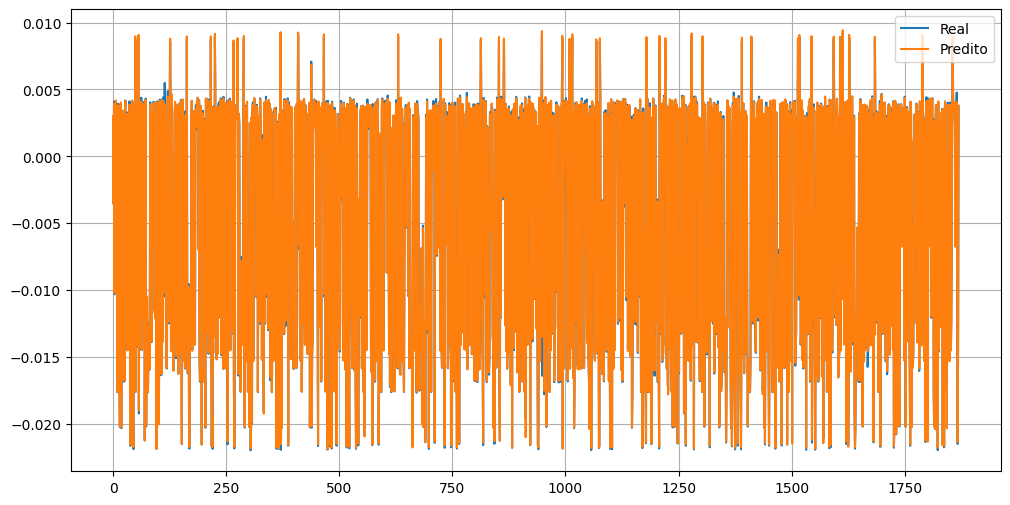

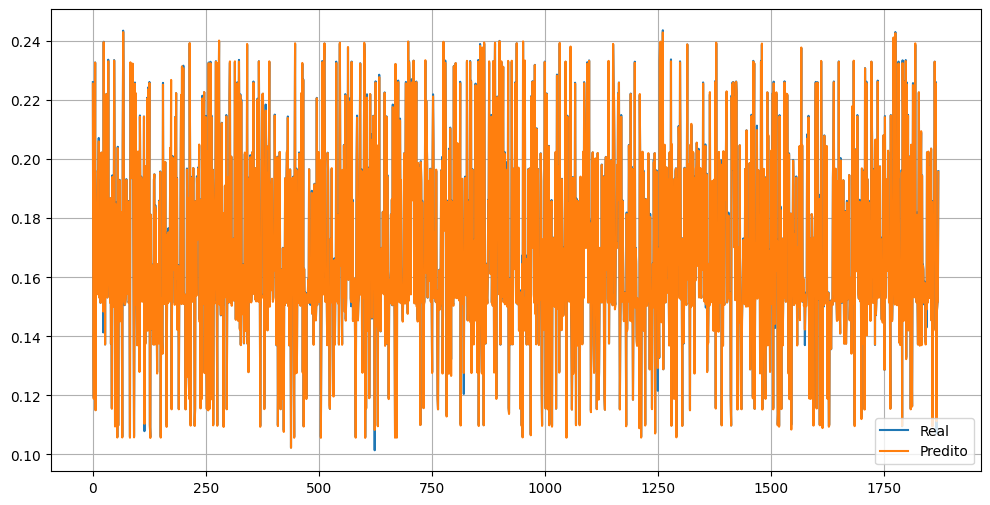

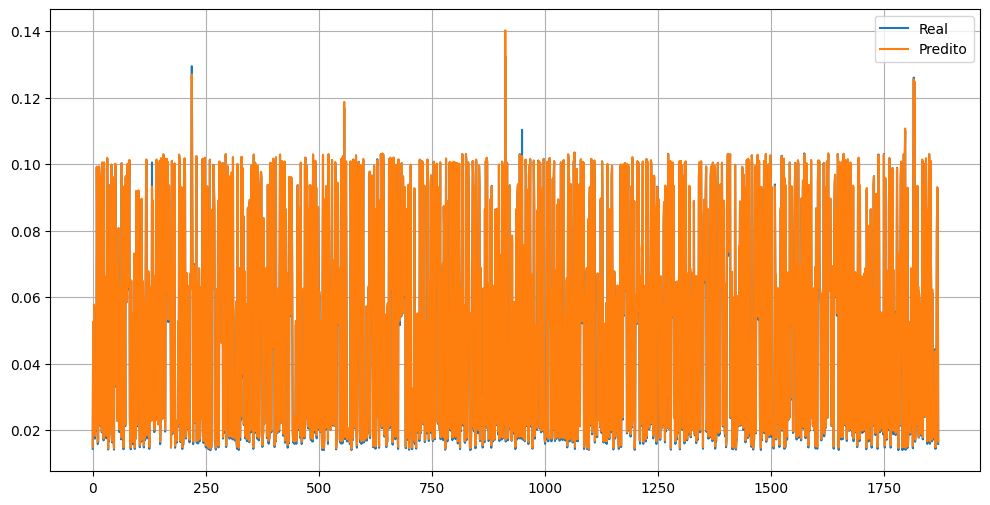

In [80]:
for i in range(len(cols)):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label='Real')
    plt.plot(y_predict[:, i], label='Predito')
    plt.legend()
    plt.grid()
    plt.show()

In [81]:
X_ = X[:, [3,6,1,5,0,4,2]]
y_p_ = model.predict(X_)

195/195 [==============================] - 0s 1ms/step


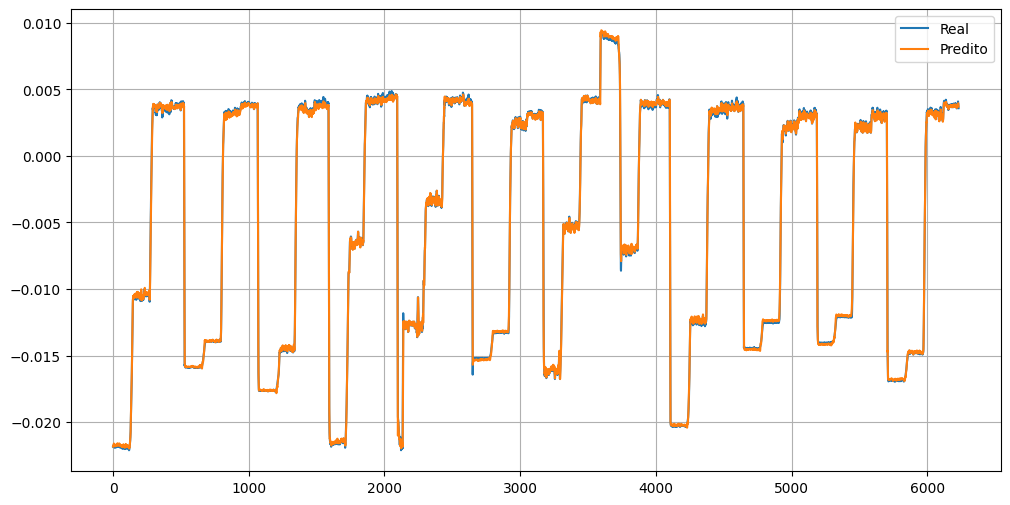

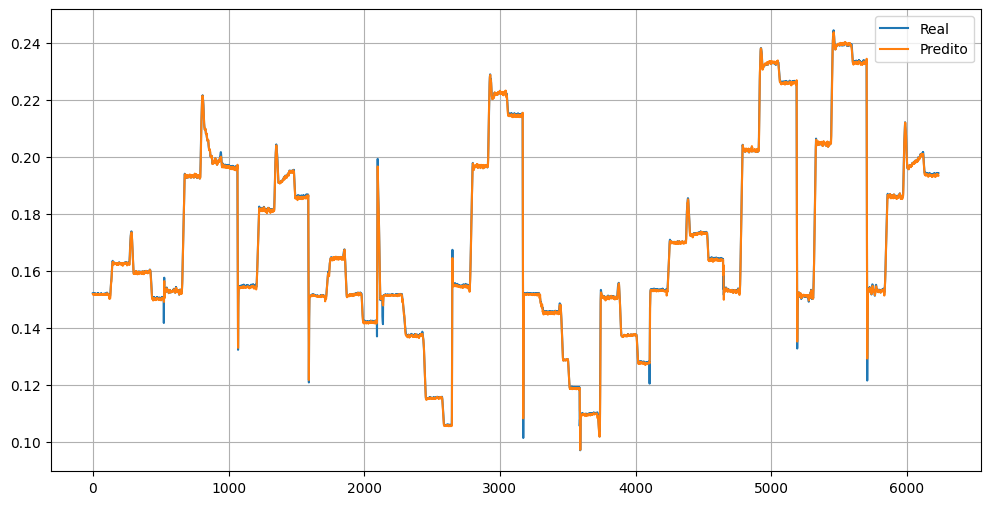

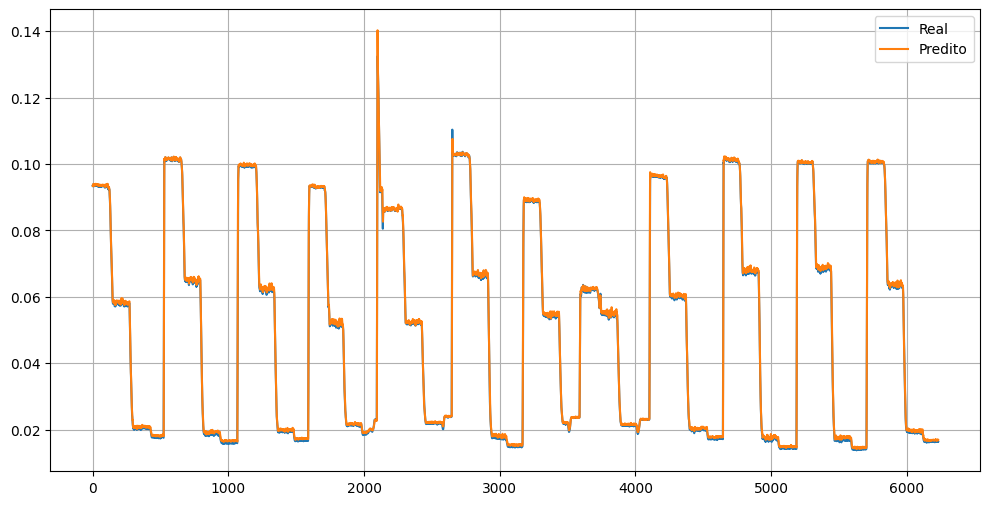

In [82]:
for i in range(len(cols)):
    plt.figure(figsize=(12, 6))
    plt.plot(y[:, i], label='Real')
    plt.plot(y_p_[:, i], label='Predito')
    plt.legend()
    plt.grid()
    plt.show()

In [83]:
model.save('modelo_RNA.h5')